# ML model to Predict future PV power

The following libraries are used in the formulation of the predictive model:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta
import requests
import xml.etree.ElementTree as ET

 ## Historical Data Preprocessing

First the historical dataset is loaded from the CSV file. Then the format of the datetime column is adjusted before checking for missing values. 

In [3]:
# Load the dataset
data = pd.read_csv('Past_PV_Power_data_50kW.csv')

# Convert 'time' column to datetime format
data['time'] = pd.to_datetime(data['time'], format='%Y%m%d:%H%M')

# Check for missing values
missing_values = data.isnull().sum()

print(missing_values)

time     0
P        0
G(i)     0
H_sun    0
T2m      0
WS10m    0
dtype: int64


Since there are no missing values in the dataset, there are no preprocessing steps necessary for dealing with the missing values.

## Data description
This historical data is then analysed to determine the mean, standard deviation, median, maximum value and minimum value for the weather variables and power generated. This analysis provides insights into the distribution and variability of the dataset. 

In [47]:
# Drop the time column for the description
data_describe = data.drop('time', axis=1)

# Calculate statistics
mean_values = data_describe.mean()
std_dev_values = data_describe.std()
median_values = data_describe.median()
max_values = data_describe.max(numeric_only=True)
min_values = data_describe.min(numeric_only=True)


# Create a DataFrame from the calculated statistics
statistics_table = pd.DataFrame({
    'Mean': mean_values,
    'Standard Deviation': std_dev_values,
    'Median': median_values,
    'Maximum': max_values,
    'Minimum': min_values
})

row_labels = {
    'P':'PV system power (W)',
    'G(i)': 'Global irradiance (W/m²)',
    'H_sun': 'Sun height (degree)',
    'WS10m': '10 metre wind speed (m/s)',
    'T2m': '2 metre air temperature (degree Celsius)'
}

statistics_table_renamed = statistics_table.rename(index = row_labels)

# Display the statistics table
statistics_table_renamed

,Mean,Standard Deviation,Median,Maximum,Minimum
PV system power (W),5110.508880,8917.500796,0.00,44991.00,0.00
Global irradiance (W/m²),129.658436,220.261547,0.00,1105.44,0.00
Sun height (degree),12.454270,17.084949,0.00,60.52,-0.57
2 metre air temperature (degree Celsius),10.016215,4.837375,10.19,28.54,-7.47
10 metre wind speed (m/s),3.137226,1.543847,2.90,13.03,0.00


## Feature Analysis
### Heatmap

The weather and climatic features are analysed in the below heatmap to identify which features have the strongest correlation with solar power generation prediction. The captured features include the gloabl irradiance, the 2 metre air temperature (degree Celsius), the sun height (degree) and the 10 metre total wind speed (m/s).

                              PV system power output (W)  \
PV system power output (W)                      1.000000   
Global irradiance (W/m²)                        0.998760   
Sun height (degrees)                            0.749460   
2 metre air temperature (°C)                    0.305441   
10 metre wind speed (m/s)                       0.065017   

                              Global irradiance (W/m²)  Sun height (degrees)  \
PV system power output (W)                    0.998760              0.749460   
Global irradiance (W/m²)                      1.000000              0.763816   
Sun height (degrees)                          0.763816              1.000000   
2 metre air temperature (°C)                  0.325303              0.494852   
10 metre wind speed (m/s)                     0.059396              0.127225   

                              2 metre air temperature (°C)  \
PV system power output (W)                        0.305441   
Global irradiance (W/m²)          

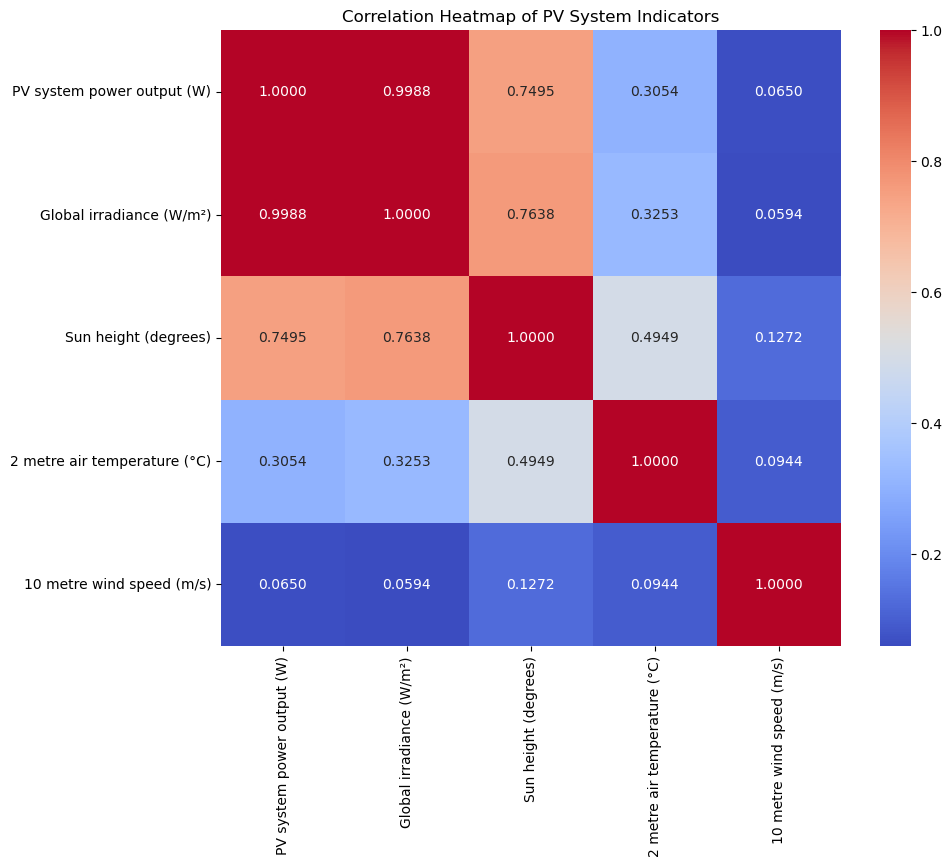

In [4]:
# Creating a DataFrame
df = pd.DataFrame(data)

# Renaming columns for clarity
df_renamed = df.rename(columns={
    "G(i)": "Global irradiance (W/m²)",
    "T2m": "2 metre air temperature (°C)",
    "WS10m": "10 metre wind speed (m/s)",
    "H_sun": "Sun height (degrees)",
    "P": "PV system power output (W)"
})

# Drop the time column for the correlation analysis
df_heat = df_renamed.drop('time', axis=1)

# Calculating the correlation matrix
corr_matrix = df_heat.corr()

print(corr_matrix)

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".4f")
plt.title('Correlation Heatmap of PV System Indicators')
plt.show()

From the above heatmap, it can be observed that the features which have the highest correlation with solar power generation are global irradiance and sun height. This suggests that as these two features increase, the PV power also increases. However, correlation does not imply causation. Correlation does not account for interactions between variables. It treats the relationship between each pair of variables in isolation. Therefore, if a feature like global irradiance already provides a significant amount of information for predicting PV power, other related features (like sun height) may show lower importance, not because they lack predictive power, but because their unique contribution, beyond what is already explained by irradiance, is smaller. It may be that sun height correlates with PV power because it's an indirect measure of the potential for solar irradiance, which is the direct driver of PV power output.

Thus, it is vital to measure the significance of each feature in the predictive model itself and how useful each feature is at improving the model's prediction accuracy. The following code executes the predictive model and illustrates the most influential features in boosting the model's predictive accuracy.

### Feature Importance

In [5]:
# Prepare the dataset for modeling
X = data[['G(i)', 'T2m', 'WS10m', 'H_sun']] 
y = data['P']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #random_state sets the same train-test split each time the code is run. 
                                                                                        #Without this, each call could result in different splits, which may lead to variations in model performance

# Initialise and train the Gradient Boosting Regressor
gbm_basic = GradientBoostingRegressor(n_estimators=500, learning_rate=0.1, max_depth=3, random_state=42) #n_estimators = number of regression trees. 
gbm_basic.fit(X_train, y_train) #GBM learns from the training data

# Predict on the testing set
y_pred_basic = gbm_basic.predict(X_test) #Predicts values for y based on test features. 

# Calculate RMSE for the predictions
rmse_basic = np.sqrt(mean_squared_error(y_test, y_pred_basic)) #y_test is actual values for y

#Calculate the RMSE for the training data. Want to make sure that the model is not overfitting
y_train_pred = gbm_basic.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))


print(f'Training RMSE: {rmse_train} Watts')
print(f'Testing RMSE: {rmse_basic} Watts')


Training RMSE: 117.06865421843494 Watts
Testing RMSE: 124.23795714203597 Watts


In [6]:
# Extract feature importance
feature_importance_values = gbm_basic.feature_importances_

# Create a pandas series for easy plotting and manipulation, assuming X_train has column names
feature_importances = pd.Series(feature_importance_values, index=X_train.columns)

# Sort the features by importance
sorted_importances = feature_importances.sort_values(ascending=False)

print(sorted_importances)

G(i)     0.998961
T2m      0.000788
WS10m    0.000208
H_sun    0.000044
dtype: float64


From these results, it is clear that the global irradiance is by far the most important feature, while the sun height is the least important in the prediction model. This doesn't diminish the role of sun height in the physical generation of solar power but indicates that, for predictive modeling purposes, direct measures of irradiance offer a much more precise tool for predicting PV output. Given this, the sun height is removed from the features for the prediction model to enhance the model's efficiency. Another reason for removing the sun height is that forecast data for the sun height are not included in the met.ie API that will be used to predict future PV power. 

In [7]:
# Prepare the dataset for modeling, removing 'H_sun'
X_final = data[['G(i)', 'T2m', 'WS10m']]  # Exclude 'H_sun' from the features since it is not an important feature and not included in met.ie API.
y_final = data['P']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42) #random_state sets the same train-test split each time the code is run. 
                                                                                        #Without this, each call could result in different splits, which may lead to variations in model performance

# Initialise and train the Gradient Boosting Regressor
gbm_basic_final = GradientBoostingRegressor(n_estimators=500, learning_rate=0.1, max_depth=3, random_state=42) #n_estimators = number of regression trees. 
gbm_basic_final.fit(X_train, y_train) #GBM learns from the training data

# Predict on the testing set
y_pred_basic_final = gbm_basic_final.predict(X_test) #Predicts values for y based on test features. 

# Calculate RMSE for the predictions
rmse_basic_final = np.sqrt(mean_squared_error(y_test, y_pred_basic_final)) #y_test is actual values for y

#Calculate the RMSE for the training data. Want to make sure that the model is not overfitting
y_train_pred_final = gbm_basic_final.predict(X_train)
rmse_train_final = np.sqrt(mean_squared_error(y_train, y_train_pred_final))


print(f'Training RMSE: {rmse_train_final} Watts')
print(f'Testing RMSE: {rmse_basic_final} Watts')

Training RMSE: 131.71596229261036 Watts
Testing RMSE: 139.1060468819065 Watts


## Forecast Data Collection
The below code is designed to fetch weather forecast data from the Met Éireann API (the Irish National Meteorological Service) and parse the XML response to extract relevant forecast variables. The forecast variables are global irradiance, the 2 metre air temperature (degree Celsius), the sun height (degree) and the 10 metre total wind speed (m/s).

For each timestep of the API there are two distinct forecast blocks, Forecast Block A and Forecast Block B. Block B is related to rainfall accumulations and weather symbols, so this block will be disregarded and only Forecast Block A will be considered when drawing data from the API. 

The API provides forecast data in one hour intervals for the first 90 hours, three hour intervals from 90 hours to 144 hours in advance and six hour intervals from 144 hours to the end of the forecast. 

In [28]:
# Define the base URL
base_url = "https://metwdb-openaccess.ichec.ie/metno-wdb2ts/locationforecast"

# Specify the latitude and longitude
lat = "52.519"
long = "-8.712"

# Specify the forecast start and end dates as datetime objects
start_date = datetime.strptime('2024-04-07T00:00', '%Y-%m-%dT%H:%M')  # Convert string to datetime
end_date = start_date + timedelta(days=1)  # Specify end date, for example one day ahead

# Format the dates back into strings in the required format for the API call
start_date_str = start_date.strftime("%Y-%m-%dT%H:%M")
end_date_str = end_date.strftime("%Y-%m-%dT%H:%M")

# Construct the complete API URL
api_url = f"{base_url}?lat={lat};long={long};from={start_date_str};to={end_date_str}"

response = requests.get(api_url)
xml_data = ET.fromstring(response.content)

# Prepare lists to hold the extracted forecast data
global_radiation = []
wind_speed = []
air_temperature = []
times = []

# Iterate over each time element in the forecast data
for time_element in xml_data.findall(".//time"):
    from_time = time_element.get('from')
    to_time = time_element.get('to')
    
    # Only process Block A where 'from' and 'to' times are the same
    if from_time == to_time:
        for location_element in time_element.findall(".//location"):
            temperature_element = location_element.find(".//temperature")
            if temperature_element is not None:
                air_temperature.append(float(temperature_element.get('value')))
            else:
                air_temperature.append(np.nan)  #Handles any missing values

            wind_speed_element = location_element.find(".//windSpeed")
            if wind_speed_element is not None:
                wind_speed.append(float(wind_speed_element.get('mps')))
            else:
                wind_speed.append(np.nan)

            global_radiation_element = location_element.find(".//globalRadiation")
            if global_radiation_element is not None:
                global_radiation.append(float(global_radiation_element.get('value')))
            else:
                global_radiation.append(0)  # Assuming night time or no data available

            times.append(from_time)
            
# Prepare the forecast DataFrame
forecast_df = pd.DataFrame({
    'time': times,
    'G(i)': global_radiation,
    'WS10m': wind_speed,
    'T2m': air_temperature
})

The missing values are then checked for. The presence of missing data can lead to poor machine learning model performance.

In [29]:
missing_values_forecast = df.isnull().sum()
print(missing_values_forecast)

time     0
P        0
G(i)     0
H_sun    0
T2m      0
WS10m    0
dtype: int64


## PV power prediction
The variables collected from the API are used to predict future photovoltaic (PV) power output employing the previously trained Gradient Boosting Machine (GBM) model. The forecasted PV power generation profile is exported to a CSV file where it can be accessed by the scheduling models. 

In [30]:
#Forecast
X_forecast = forecast_df[['G(i)', 'T2m', 'WS10m']]

# Predict future PV power output using the prepared forecast data
predicted_pv_output = gbm_basic_final.predict(X_forecast)

# Set any PV power output below 10 watts to 0. 
predicted_pv_output_adjusted = np.where(predicted_pv_output < 10, 0, predicted_pv_output)

# Create a DataFrame for the predicted output with adjusted values
output_df = pd.DataFrame({
    'time': forecast_df['time'],
    'predicted_PV_output (W)': predicted_pv_output_adjusted
})

# Export predicted values to a CSV file
output_csv_path = 'future_PV_power_predictions.csv'
output_df.to_csv(output_csv_path, index=False)

print(f'Predicted PV power output for future dates has been saved to {output_csv_path}')

Predicted PV power output for future dates has been saved to future_PV_power_predictions.csv
